In [1]:
import os
import gym
import time
import random
import pickle
import numpy as np
import pandas as pd
from itertools import chain
from collections import deque
from operator import itemgetter
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
import matplotlib.pyplot as plt

plt.style.use('seaborn')

/Users/Admin/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class DQN(object):
    """Deep Q-network training and testing framework.
    
    Parameters
    ----------
    env_id : str
        Gym environment ID.
    
    agent_hist_len : int, default: 4
        Number of most recent states the agent experienced that are fed into the
        Q-network.
    
    memory_size : int, default: 10000
        Replay memory size.
    
    replay_start_size : int, default: 10000
        Draw this number of random uniform samples from action space to populate
        replay memory before learning starts.
    
    gamma : float, default: 0.99
        Discount factor.
    
    eps : float, default: 1.0
        Initial value of epsilon in epsilon-greedy exploration.
    
    eps_min : float, default: 0.1
        Final value of epsilon in epsilon-greedy exploration.
    
    final_expl_step : int, default: 1000
        Number of time steps over which the initial value of epsilon is annealed
        to its final value.
    
    mb_size : int, default: 32
        Number of training examples that stochastic gradient descent passes
        through at each replay.
    
    C : int, default: 100
        Target network update frequency.
    
    n_episodes : int, default: 500
        Number of episodes to train the agent on.
    
    max_steps : int, default: 500
        Number of time steps to run in each learning episode.
    """
    
    def __init__(self, env_id, agent_hist_len=4, memory_size=10000,
                 replay_start_size=10000, gamma=0.99, eps=1.0, eps_min=0.1,
                 final_expl_step=1000, mb_size=32, C=100, n_episodes=500,
                 max_steps=500):
        
        self.env_id = env_id
        self.env = gym.make(env_id)
        self.path = './data/' + env_id
        self.agent_hist_len = agent_hist_len
        self.memory_size = memory_size
        self.replay_start_size = replay_start_size
        self.gamma = gamma
        self.eps = eps
        self.eps_min = eps_min
        self.final_expl_step = final_expl_step
        self.eps_decay = (eps-eps_min) / final_expl_step
        self.mb_size = mb_size
        self.C = C
        self.n_episodes = n_episodes
        self.max_steps = max_steps
        
        # Initialize replay memory and fit feature scaler
        self._init_memory()
        self.scaler = StandardScaler()
        self.scaler.fit(np.array([t[0] for t in self.memory]))
    
    @staticmethod
    def _flatten_deque(d):
        """Flatten input deque into a 1D array."""
        return np.array(list(chain(*d)))
    
    def _get_optimal_action(self, network, agent_hist):
        """Use given network to compute optimal action for an agent history."""
        agent_hist_normalized = self.scaler.transform(
            self._flatten_deque(agent_hist).reshape(1, -1))
        return np.argmax(network.predict(agent_hist_normalized)[0])
    
    def _get_action(self, agent_hist=None):
        """Determine optimal action.
        
        Parameters
        ----------
        agent_hist : deque of 1D arrays or None, optional
            Most recent ``agent_hist_len`` states the agent experienced, where
            each array represents one state. If passed, determine action based
            on epsilon-greedy policy; otherwise choose random action.
        """
        if agent_hist is None:
            return self.env.action_space.sample()
        else:
            # Anneal epsilon
            self.eps = max(self.eps - self.eps_decay, self.eps_min)
            # Epsilon-greedy policy
            if np.random.random() < self.eps:
                return self.env.action_space.sample()
            else:
                return self._get_optimal_action(self.Q, agent_hist)
    
    def _remember(self, agent_hist, action, reward, new_state, done):
        """Store a transition in replay memory."""
        self.memory.append([self._flatten_deque(agent_hist), action, reward,
                            new_state if not done else None])
    
    def _init_memory(self):
        """Initialize memory before learning."""
        print('Initializing replay memory: ', end='')
        self.memory = deque(maxlen=self.memory_size)
        while True:
            state = self.env.reset()
            # Reset agent history at episode start
            agent_hist = deque(maxlen=self.agent_hist_len)
            agent_hist.append(state)
            while True:
                action = self._get_action(agent_hist=None)
                new_state, reward, done, _ = self.env.step(action)
                if len(agent_hist) == self.agent_hist_len:
                    self._remember(agent_hist, action, reward, new_state, done)
                if len(self.memory) == self.replay_start_size:
                    print('done')
                    return
                if done:
                    break
                state = new_state
                agent_hist.append(state)
    
    def _build_network(self):
        """Build deep neural network."""
        nn = Sequential()
        nn.add(Dense(20, activation='relu',
                     input_dim=(self.agent_hist_len
                                * self.env.observation_space.shape[0])))
        nn.add(Dense(20, activation='relu'))
        nn.add(Dense(10, activation='relu'))
        nn.add(Dense(self.env.action_space.n))
        nn.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return nn
    
    def _clone_network(self, nn):
        """Clone input network."""
        clone = self._build_network()
        clone.set_weights(nn.get_weights())
        return clone
    
    def _get_samples(self):
        """Return sample agent histories and corresponding rewards."""
        # Draw samples from replay memory
        samples = random.sample(self.memory, self.mb_size)
        # Get agent histories
        agent_hists = np.array([s[0] for s in samples])
        # Predict for agent histories using target network
        Y = self.target_Q.predict(self.scaler.transform(agent_hists))
        # Get actions
        actions = [s[1] for s in samples]
        # Get current rewards
        rewards = np.array([s[2] for s in samples])
        # Compute future rewards
        future_rewards = np.zeros(self.mb_size)
        new_states_idx = [i for i, s in enumerate(samples) if s[3] is not None]
        new_states = np.array([s[3] for s in itemgetter(*new_states_idx)(samples)])
        # For each agent history, remove the first state and append new state
        new_agent_hists = np.hstack(
            [agent_hists[new_states_idx, self.env.observation_space.shape[0]:],
             new_states])
        future_rewards[new_states_idx] = np.max(
            self.target_Q.predict(self.scaler.transform(new_agent_hists)), axis=1)
        # Add to current rewards
        rewards += self.gamma*future_rewards
        # Update predicted rewards
        for i, r in enumerate(Y):
            Y[i, actions[i]] = rewards[i]
        return agent_hists, Y
    
    def _replay(self):
        """Run stochastic gradient descent over sampled transitions."""
        agent_hists, Y = self._get_samples()
        agent_hists_normalized = self.scaler.transform(agent_hists)
        for i in range(self.mb_size):
            self.Q.train_on_batch(agent_hists_normalized[i, :].reshape(1, -1),
                                  Y[i, :].reshape(1, -1))
    
    def learn(self, render=False, verbose=True):
        """Learn Q-network and save results."""
        
        # Initialize networks
        self.Q = self._build_network()
        self.target_Q = self._clone_network(self.Q)
        
        if verbose:
            print('Learning target network:')
        self.scores = []
        for episode in range(self.n_episodes):
            state = self.env.reset()
            # Reset agent history at episode start
            agent_hist = deque(maxlen=self.agent_hist_len)
            agent_hist.append(state)
            score = 0
            for step in range(self.max_steps):
                if render:
                    self.env.render()
                # Choose random action while agent history has not reached maxlen
                if len(agent_hist) < self.agent_hist_len:
                    action = self._get_action(agent_hist=None)
                else:
                    action = self._get_action(agent_hist)
                new_state, reward, done, _ = self.env.step(action)
                if verbose:
                    print('episode: {:4} | step: {:3} | memory: {:6} | \
eps: {:.4f} | action: {} | reward: {: .1f} | best score: {: 6.1f} | \
mean score: {: 6.1f}'.format(
                        episode+1, step+1, len(self.memory), self.eps, action, reward,
                        max(self.scores) if len(self.scores) != 0 else np.nan,
                        np.mean(self.scores) if len(self.scores) != 0 else np.nan),
                        end='\r')                        
                score += reward
                if len(agent_hist) == self.agent_hist_len:
                    self._remember(agent_hist, action, reward, new_state, done)
                    self._replay()
                # Update target network every C steps
                if step % self.C == 0:
                    self.target_Q = self._clone_network(self.Q)
                if done:
                    self.scores.append(score)
                    break
                state = new_state
                agent_hist.append(state)
        
        # Save target network and score history
        self.target_Q.save(self.path + '_model.h5')
        with open(self.path + '_scores.pkl', 'wb') as f:
            pickle.dump(self.scores, f)
    
    def plot_training_scores(self):
        """Plot average scores against training episodes."""
        with open(self.path + '_scores.pkl', 'rb') as f:
            scores = pd.Series(pickle.load(f))
        avg_scores = scores.cumsum() / (scores.index + 1)
        plt.figure(figsize=(12, 6))
        n_scores = len(scores)
        plt.plot(range(n_scores), scores, color='gray', linewidth=1)
        plt.plot(range(n_scores), avg_scores)
        plt.margins(0.02)
        plt.xlabel('Training episodes')
        plt.ylabel('Average score per episode')
        plt.title(self.env_id)
        plt.tight_layout()
        plt.show()
    
    def run(self, render=True):
        """Run environment using learnt Q-network."""
        
        fname = self.path + '_model.h5'
        if os.path.exists(fname):
            self.target_Q = load_model(fname)
        else:
            print('Q-network not found. Start learning.')
            self.learn()
        
        state = self.env.reset()
        # Repeat initial state to populate agent history
        agent_hist = deque(maxlen=self.agent_hist_len)
        agent_hist.extend([state]*self.agent_hist_len)
        score = 0
        while True:
            if render:
                self.env.render()
            action = self._get_optimal_action(self.target_Q, agent_hist)
            new_state, reward, done, _ = self.env.step(action)
            score += reward
            if done:
                print('{} score: {}'.format(self.env_id, score))
                return
            state = new_state
            agent_hist.append(state)
            time.sleep(0.05)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Initializing replay memory: done


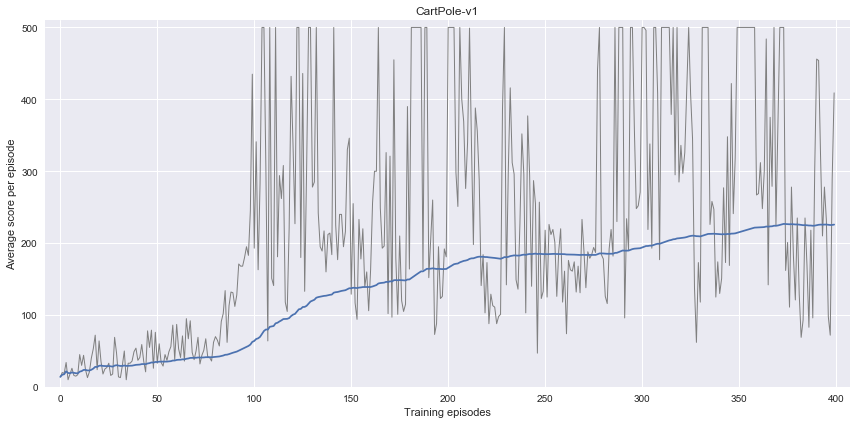

CartPole-v1 score: 500.0


In [3]:
dqn = DQN('CartPole-v1', memory_size=2000, replay_start_size=32, eps_min=1e-4,
          n_episodes=400)
dqn.learn()
dqn.plot_training_scores()
dqn.run()